In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio 
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler

from tslearn.piecewise import PiecewiseAggregateApproximation

from matrixprofile import *

import stumpy
from tqdm.notebook import tqdm
import gc
from matplotlib.patches import Rectangle
from pyts.transformation import ShapeletTransform
from matrixprofile.discords import discords

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = np.load("DATASETS/TimeSeriesTrimmed/X_train.npy")
y_train = pd.read_csv('DATASETS/TimeSeriesTrimmed/y_train.csv')

In [3]:
sample_idxs=y_train.groupby('emotion')['filename'].apply(lambda s: s.sample(20)).index.get_level_values(1)

In [4]:
X_train=X_train[sample_idxs]
y_train=y_train.iloc[sample_idxs]
X_train.shape

(160, 243200)

In [5]:
emotion_mapper = {"neutral":0, "calm":1, "happy":2, "sad":3, "angry":4, "fearful":5, "disgust":6, "surprised":7}
y_train = y_train["emotion"].replace(emotion_mapper)

In [6]:
n_paa_segments = 1000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

X_train_paa = list()
for ts in tqdm(X_train):
    ts = ts[~np.isnan(ts)].reshape(1,-1)
    ts_paa = paa.fit_transform(ts).squeeze()
    X_train_paa.append(ts_paa)
      
X_train=np.array(X_train_paa)
del X_train_paa
gc.collect()

  0%|          | 0/160 [00:00<?, ?it/s]

27

# Matrix Profile

In [7]:
w=50
matrix_profile = list()
matrix_profile_index = list()
for ts in tqdm(X_train):
    mp = stumpy.stump(ts, m=w)
    matrix_profile.append(mp[:,0])
    matrix_profile_index.append(mp[:,1])

  0%|          | 0/160 [00:00<?, ?it/s]

# Shapelets extraction 

In [8]:
# Shapelet transformation
st = ShapeletTransform(n_shapelets=8,
                        window_sizes=[50],
                        sort=True,
                        n_jobs=-1,
                        verbose=50)
st.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

ShapeletTransform(n_jobs=-1, n_shapelets=8, sort=True, verbose=50,
                  window_sizes=[50])

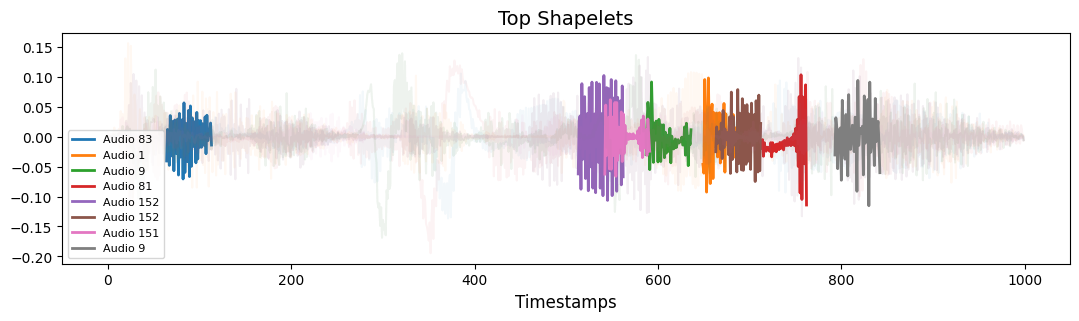

In [12]:
plt.figure(figsize=(13, 3))
for i, index in enumerate(st.indices_):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),alpha=0.05)
    plt.plot(np.arange(start, end), X_train[idx, start:end],lw=2, color='C{}'.format(i),alpha=1,label='Audio {}'.format(idx))

plt.xlabel('Timestamps', fontsize=12)
plt.title('Top Shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

In [13]:
from scipy.spatial.distance import euclidean
from tslearn.metrics import dtw

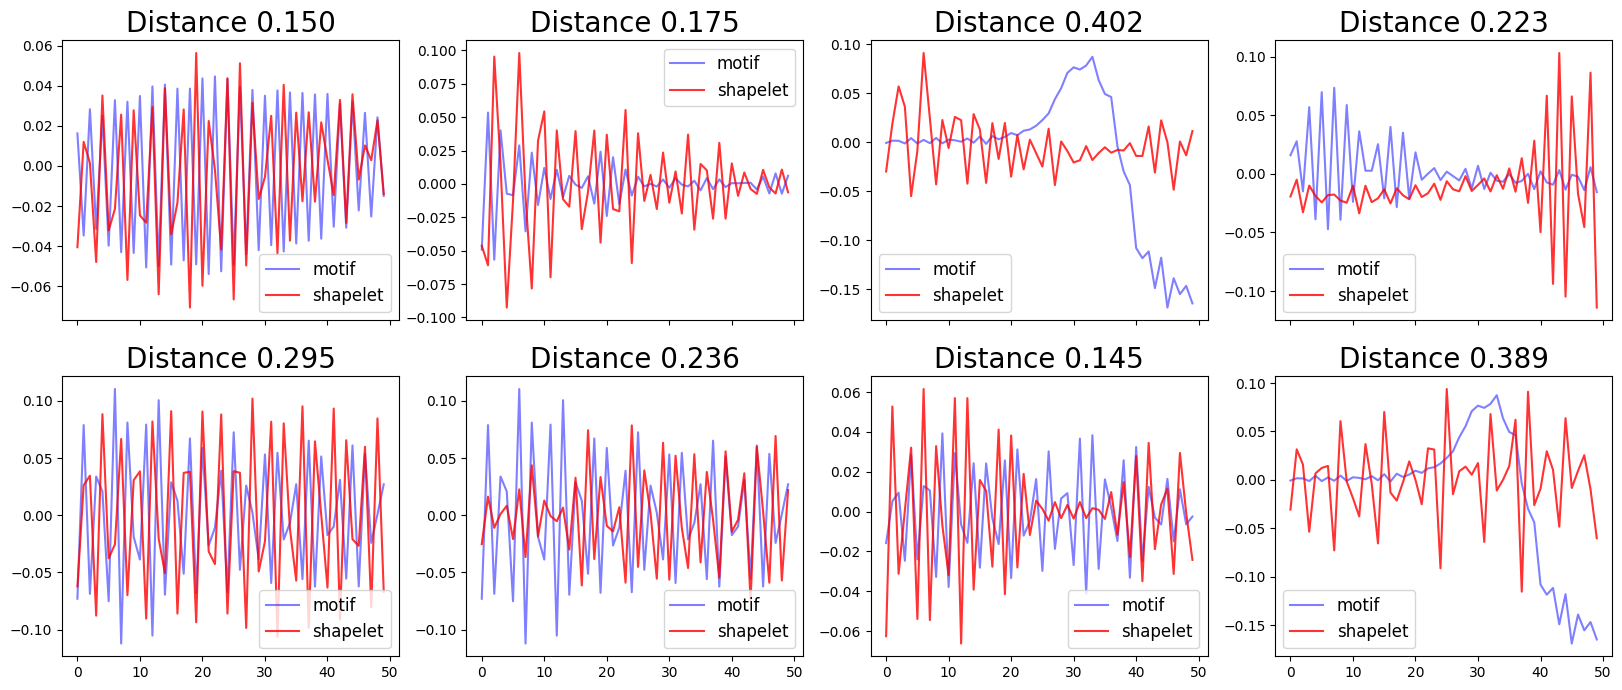

In [14]:
fig, axs = plt.subplots(nrows=2,ncols=4, sharex=True,figsize=(20,8))
row=0
for i,index in enumerate(st.indices_):
    idx, start, end = index
    shp_shape=X_train[idx, start:end]
    mo,_= motifs.motifs(X_train[idx], (matrix_profile[idx], matrix_profile_index[idx]), max_motifs=1,n_neighbors=1)
    m_shape = X_train[idx][mo[0][0]:mo[0][0]+w]
    axs[row][i%4].plot(m_shape,color="blue",label="motif",alpha=0.5)
    axs[row][i%4].plot(shp_shape,color="red",label="shapelet",alpha=0.8)
    dist=dtw(shp_shape, m_shape)
    axs[row][i%4].set_title('Distance {:.3f}'.format(dist),fontsize=20)
    axs[row][i%4].legend(loc='best', fontsize=12)
    if(i==3):row=1


[[7, 931]]
[[102, 502]]
[[102, 502]]
[[102, 502]]
[[631, 767]]
[[631, 767]]
[[191, 205]]
[[102, 502]]


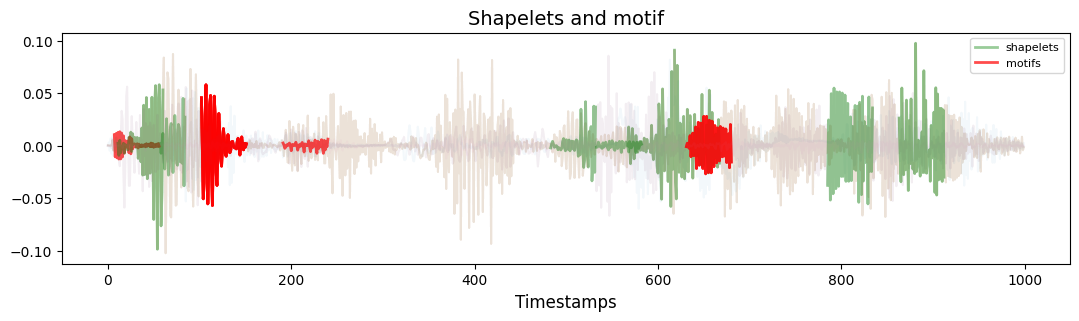

In [50]:
plt.figure(figsize=(13, 3))
for i, index in enumerate(st.indices_):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),alpha=0.05)
    plt.plot(np.arange(start, end), X_train[idx, start:end],lw=2,label="shapelets" ,color="green",alpha=0.4)
    mo,_= motifs.motifs(X_train[idx], (matrix_profile[idx], matrix_profile_index[idx]), max_motifs=1,n_neighbors=1)
    print(mo)
    m_shape = X_train[idx][mo[0][0]:mo[0][0]+w]
    plt.plot(range(mo[c][0],mo[c][0]+w), m_shape,label="motifs", color="red", lw=2,alpha=0.7)
    if(i==0):plt.legend(loc='best', fontsize=8)
plt.xlabel('Timestamps', fontsize=12)
plt.title('Shapelets and motif', fontsize=14)
plt.show()

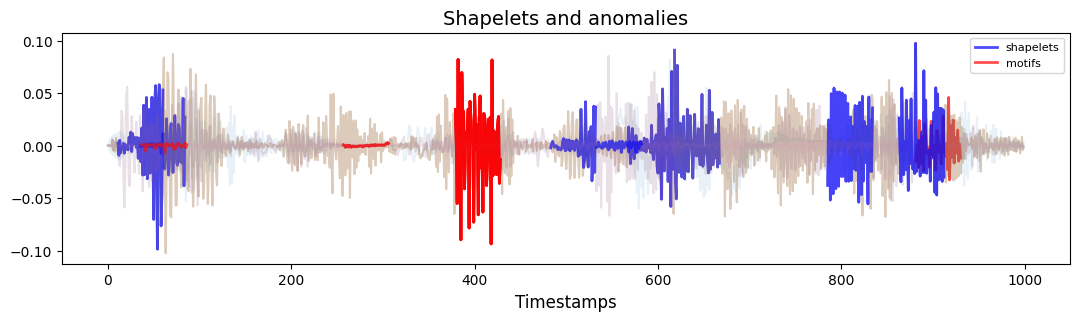

In [46]:
plt.figure(figsize=(13, 3))
for i, index in enumerate(st.indices_):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),alpha=0.1)
    plt.plot(np.arange(start, end), X_train[idx, start:end],lw=2, color="blue",label="shapelets",alpha=0.7)
    a = discords(matrix_profile[idx], ex_zone=5, k=1)
    for anom in a:
        a_shape = X_train[idx][anom:anom+w]
        plt.plot(range(anom,anom+w), a_shape, color="red", lw=2,label="motifs",alpha=0.7)
    if(i==0):plt.legend(loc='best', fontsize=8)
plt.xlabel('Timestamps', fontsize=12)
plt.title('Shapelets and anomalies', fontsize=14)
#plt.legend(loc='best', fontsize=8)
plt.show()